## MTA Turnstile Analysis Project
by Ozzie Liu  
ozzie@ozzieliu.com  
This is the iPython Notebook file of the work I did for the project.  
For details, check out my blog post: http://ozzieliu.com/2016/02/22/mta-data-analysis-for-wtwy-part-1/

In [1]:
import datetime
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import os

# Load turnstile data

In [2]:
## Load 1 subway file
subway = pd.read_csv('mta/turnstile_150404.txt')
## Fix column names in case there's trailing whitespaces
subway.columns = [col.strip() for col in list(subway.columns)]

## Get the difference between Entries and Exits counters in new columns. 
subway['d_Entries'] = subway.ENTRIES.shift(-1)-subway.ENTRIES
subway['d_Exits'] = subway.EXITS.shift(-1) - subway.EXITS

## That was an easy way to calculate difference, but there will be discrepency with different turnstiles.
## Here we get rid of outliers and negative numbers. Upper limit for realistic volume is 5000
subway = subway[(subway.d_Entries > 0) & (subway.d_Entries < 5000) & 
                (subway.d_Exits > 0) & (subway.d_Exits < 5000)]

## Create datetime column
subway['datetime'] = pd.to_datetime(subway.DATE + subway.TIME, format='%m/%d/%Y%H:%M:%S')

## Drop columns that I don't need: Division, Date, Time, DESC, Entries, and Exits
subway = subway.drop(['DIVISION', 'TIME', 'DESC', 'ENTRIES', 'EXITS'], 1)

In [3]:
## Helper function
def load_preprocess_file(filename):
    """
    load_preprocess_file takes the filename of a raw MTA turnstile csv file and calculates the daily entries and exits,
    set up a datetime column, filters out the outlier data, and drops some columns not needed in this project.
    Returns a clean Pandas dataframe
    """
    ## Load file
    df = pd.read_csv(filename)
    df.columns = [col.strip() for col in list(df.columns)]
    
    ## Get the difference between Entries and Exits counters in new columns. 
    df['d_Entries'] = df.ENTRIES.shift(-1) - df.ENTRIES
    df['d_Exits'] = df.EXITS.shift(-1) - df.EXITS

    ## That was an easy way to calculate difference, but there will be discrepency with different turnstiles.
    ## Here we get rid of outliers and negative numbers. Upper limit for realistic volume is 5000
    df = df[(df.d_Entries > 0) & (df.d_Entries < 5000) & 
            (df.d_Exits > 0) & (df.d_Exits < 5000)]
    
    ## Datetime format
    df['datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')
    
    ## Drop columns
    df = df.drop(['DIVISION', 'TIME', 'DESC', 'ENTRIES', 'EXITS'], 1)
    return df

subway = load_preprocess_file('mta/turnstile_150411.txt')

## Plot turnstile data by day or entire week 

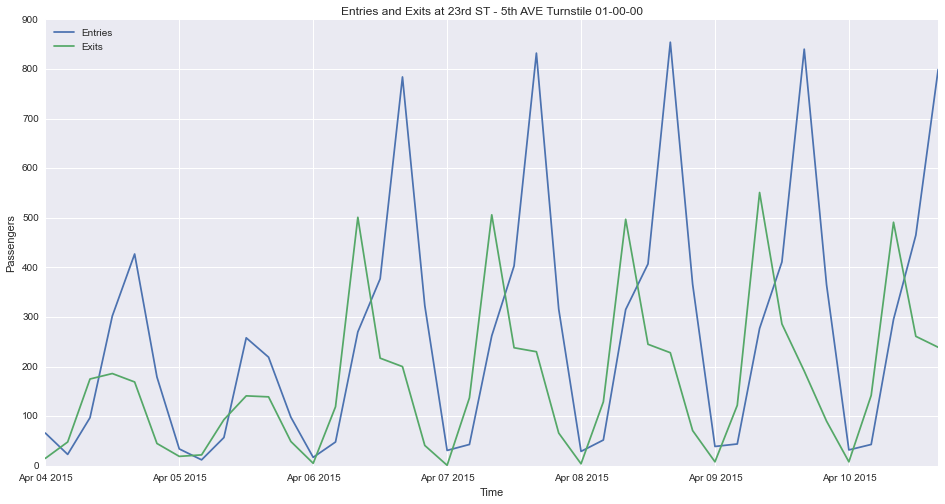

In [4]:
def plot_turnstile(dataframe, turnstile_key, time = 'week'):
    """
    plot_turnstile plots the entries and exits of a turnstile based on a specific key.
    dataframe: the pre-processed pandas dataframe of MTA turnstile data.
    turnstile_key: a tuple with C/A, UNIT, SCP, and STATION of the selected turnstile
    time: int for day of week to plot. 0 is Saturday, 6 is Friday.
        if default of 'week', plots entire week
    """
    if time == 'week':
        grouped = dataframe.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])
        turnstile = grouped.get_group(turnstile_key)
        x = turnstile['datetime']
        entries = turnstile['d_Entries']
        exits = turnstile['d_Exits']
    
    else:
        day_of_week = dataframe.DATE.unique()[time]
        group_key = turnstile_key + (day_of_week,)
        grouped = dataframe.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])
        turnstile = grouped.get_group(group_key)
        x = turnstile['datetime']
        entries = turnstile['d_Entries']
        exits = turnstile['d_Exits']
    
    ## Plot it
    plt.figure(figsize=(16,8))
    plt.plot(x, entries, label='Entries')
    plt.plot(x, exits, label='Exits')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.legend(loc='upper left')
    
plot_turnstile(subway, ('A030', 'R083', '01-00-00', '23 ST-5 AVE'))
plt.title('Entries and Exits at 23rd ST - 5th AVE Turnstile 01-00-00')

## Plot every turnstile at a station

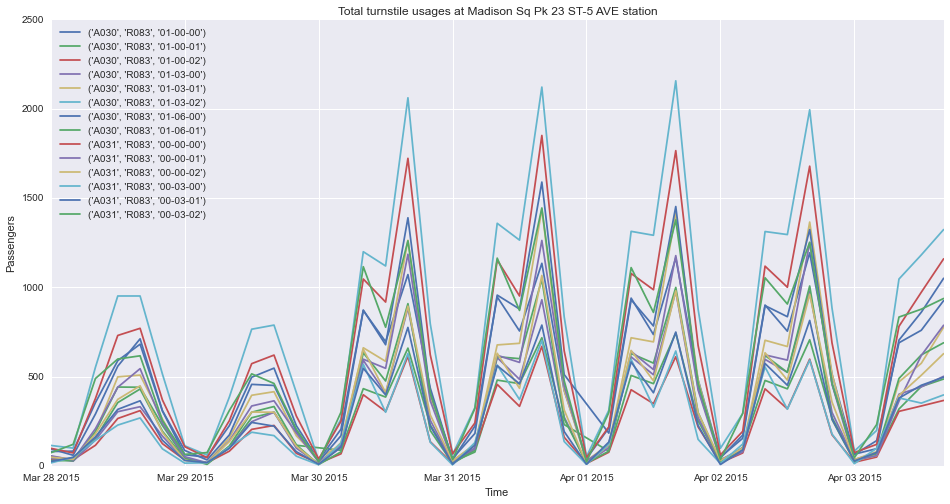

In [377]:
def plot_every_turnstile(dataframe, station_name, scale = 'week', data = 'total'):
    """
    plot_every_turnstile plots every turnstile in a given station by a given timeframe and with a specified set of data
    dataframe: pre-processed pandas dataframe of MTA turnstile data
    station_name: string of 1 station's name
    scale: 'week' for a daily view, and 'daily' for a granular 4 hour/day data
    data: 'entries' for turnstile entries. 'exits' for turnstile exits. 'total' for entries + exits
    """
    ## Check which column to use
    if data == 'entries':
        data = 'd_Entries'
    elif data == 'exits':
        data = 'd_Exits'
    else:
        dataframe['total'] = dataframe['d_Entries'] + dataframe['d_Exits']
        
    grouped = subway.groupby(['STATION'])
    station = grouped.get_group(station_name)
    turnstiles = station.groupby(['C/A', 'UNIT', 'SCP'])

    plt.figure(figsize=(16,8))
    
    if scale == 'week':
        for index, turn in turnstiles:
            t = turn.groupby('DATE').sum()
            x = pd.to_datetime(t.index)
            y = t[data]
            plt.plot(x, y, label = index)
    
    else:
        for index, turn in turnstiles:
            t = turn.groupby('datetime').sum()
            x = t.index
            y = t[data]
            plt.plot(x, y, label = index)
    
    ## Add some labels
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.legend(loc='upper left')
    
# plot_every_turnstile(subway, '5 AVE-59 ST', scale = 'day', data = 'total')
plot_every_turnstile(subway, '23 ST-5 AVE', scale = 'day', data = 'total')
plt.title('Total turnstile usages at Madison Sq Pk 23 ST-5 AVE station')

## Plot station level passengers by day or entire week

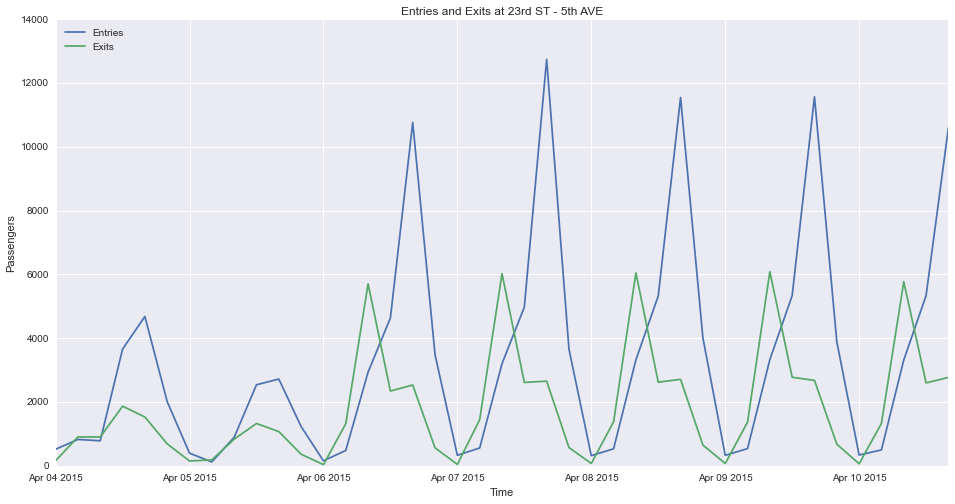

In [5]:
def plot_station(dataframe, station_name, time = 'week'):
    """
    plot_station plots the entries and exits of all turnstile in a station based on its station name.
    dataframe: the pre-processed pandas dataframe of MTA turnstile data.
    station_name: a string of the station's name
    time: int for day of week to plot. 0 is Saturday, 6 is Friday.
        if default of 'week', plots entire week
    """
    
    if time == 'week':
        grouped = dataframe.groupby(['STATION'])
        station = grouped.get_group(station_name)
        ## Group by datetime to aggregate across all turnstiles
        total = station.groupby('datetime').sum()
        x = total.index
        entries = total['d_Entries']
        exits = total['d_Exits']
    
    else:
        day_of_week = dataframe.DATE.unique()[time]
        group_key = (station_name,) + (day_of_week,)
        grouped = dataframe.groupby(['STATION', 'DATE'])
        station = grouped.get_group(group_key)
        total = station.groupby('datetime').sum()
        x = total.index
        entries = total['d_Entries']
        exits = total['d_Exits']
    
    
    ## Plot it
    plt.figure(figsize=(16,8))
    plt.plot(x, entries, label='Entries')
    plt.plot(x, exits, label='Exits')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.legend(loc='upper left')
    
plot_station(subway, '23 ST-5 AVE',)
plt.title('Entries and Exits at 23rd ST - 5th AVE')

## Calculate total passengers of each station for 1 week

In [6]:
def station_total(dataframe, column = 'total'):
    """
    station_total takes a pre-processed turnstile dataframe and returns the sum of each station's turnstile use.
    column selected for aggregation can be 'entries', 'exits', or 'total'
    Returns a dataframe of the station name, and the total sum
    """
    ## Group by STATION, even though this may end up lumping some smaller stations together.
    grouped = dataframe.groupby(['STATION', 'LINENAME']).sum()
    ## New column for total
    grouped['total'] = grouped.d_Entries + grouped.d_Exits
    
    if column == 'entries':
        total = grouped.d_Entries.sort_values(by=['d_Entries'], axis=0, ascending=False)
    elif column == 'exits':
        total = grouped.d_Exits.sort_values(by=['d_Exits'], axis=0, ascending=False)
    else:
        total = grouped.total.sort_values(ascending=False)

    return pd.DataFrame(total)


top_stations = station_total(subway, 'total')
top_stations.head(10)

,,total
STATION,LINENAME,
42 ST-GRD CNTRL,4567S,1747385
34 ST-HERALD SQ,BDFMNQR,1419312
42 ST-TIMES SQ,1237ACENQRS,1046048
34 ST-PENN STA,ACE,1021613
42 ST-PA BUS TE,ACENQRS1237,896345
14 ST-UNION SQ,LNQR456,815698
86 ST,456,754797
47-50 ST-ROCK,BDFM,739774
MAIN ST,7,648390


## Graph of top 20 stations usage over a week

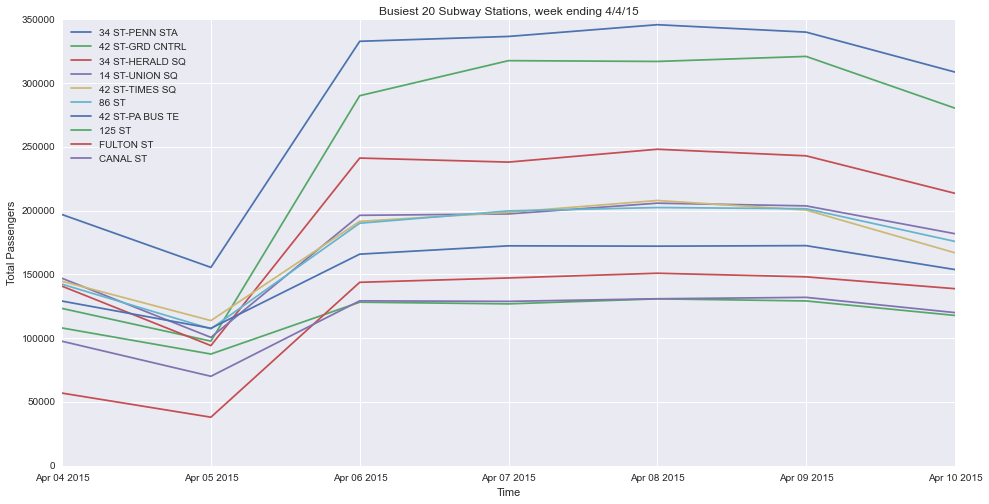

In [402]:
def plot_top_stations(dataframe, station_list, timeframe = 'day'):
    """
    plot_top_stations plots the total entries and exits of stations give in station list
    dataframe: the pre-processed pandas dataframe of MTA turnstile data.
    station_list: a list of station names to plot
    timeframe: 'day' for a 7 day/week scale. 'hour' for a smaller scale of 4 hour blocks each day of the week
    """
    dataframe['total'] = dataframe['d_Entries'] + dataframe['d_Exits']
    grouped = dataframe.groupby(['STATION'])
    
    plt.figure(figsize=(16,8))
    
    ## Now plot each station onto the graph
    for station in station_list:
        s = grouped.get_group(station)
        
        if timeframe != 'hourly':
            total = s.groupby('DATE').sum()
        else:
            total = s.groupby('datetime').sum()
            
        x = pd.to_datetime(total.index)
        y = total.total
        plt.plot(x, y, label = station)
        
    plt.xlabel('Time')
    plt.ylabel('Total Passengers')
    plt.legend(loc = 'upper left')
    
    
        
## Get top n busiest stations and plot them.
n = 10
top10_stations = list(top_stations.index)[:n]

plot_top_stations(subway, top10_stations)
plt.title('Busiest 10 Subway Stations, week ending 4/4/15')

## Get weekly average over season

In [436]:
mta_files = os.listdir("mta")[1:]
season_df = pd.DataFrame()

In [438]:
for mta_file in mta_files:
    date = mta_file[10:16]
    week = load_preprocess_file('mta/' + mta_file)
    total = station_total(week)
    total.columns = [date]
    season_df = pd.concat([season_df, total], axis= 1)

In [439]:
season_df.head()

150404  150411  150418  150425  150502  150509  \
STATION       LINENAME                                                   
1 AVE         L         313195  282114  310768  237847  231757  227843   
103 ST        1         108395  119225  126984   99290  115415  108585   
              6         182550  164557  195907  189044  188173  141689   
              BC         51777   48511   52498   56696   55815   58308   
103 ST-CORONA 7         216734  210694  204015  223677  201186  225375   

                        150516  150523  150530  150606  150613  150620  150627  
STATION       LINENAME                                                          
1 AVE         L         229240  232924  264537  317561  322032  317499  306762  
103 ST        1         124782  130136  113580   99215  126260  125599  122901  
              6         129922  125648  114130  125529  125873  116840  118350  
              BC         53927   53173   43688   56640   50729   52929   48410  
103 ST-CORONA 7         221724  248834  215619  221601  212062  220953  197899

In [440]:
season_average = season_df.mean(axis=1).sort_values(ascending = False)
season_average.head(10)

STATION          LINENAME   
42 ST-GRD CNTRL  4567S          1738601.000000
34 ST-HERALD SQ  BDFMNQR        1411616.076923
42 ST-TIMES SQ   1237ACENQRS    1008596.000000
34 ST-PENN STA   ACE             985054.153846
42 ST-PA BUS TE  ACENQRS1237     869653.923077
14 ST-UNION SQ   LNQR456         864844.153846
86 ST            456             776311.384615
47-50 ST-ROCK    BDFM            713272.923077
MAIN ST          7               680105.153846
59 ST-COLUMBUS   ABCD1           661871.769231
dtype: float64

In [435]:
## TESTING: Grouping by station and linename for the top stations
subway.groupby(['STATION', 'LINENAME']).sum().total.sort_values(ascending = False)

STATION          LINENAME   
42 ST-GRD CNTRL  4567S          1747385
34 ST-HERALD SQ  BDFMNQR        1419312
42 ST-TIMES SQ   1237ACENQRS    1046048
34 ST-PENN STA   ACE            1021613
42 ST-PA BUS TE  ACENQRS1237     896345
14 ST-UNION SQ   LNQR456         815698
86 ST            456             754797
47-50 ST-ROCK    BDFM            739774
MAIN ST          7               648390
59 ST            456NQR          604764
59 ST-COLUMBUS   ABCD1           603226
34 ST-PENN STA   123ACE          573880
W 4 ST-WASH SQ   ABCDEFM         552484
ROOSEVELT AVE    EFMR7           540367
PATH WTC         1               523268
CANAL ST         JNQRZ6          513082
LEXINGTON-53 ST  EM6             501891
FULTON ST        2345ACJZ        490593
42 ST-BRYANT PK  BDFM7           457287
96 ST            123             432635
72 ST            123             427306
34 ST-PENN STA   123             421096
14 ST-UNION SQ   456LNQR         417537
JAMAICA CENTER   EJZ             414940
77 ST      